# Histogram

I need to get DFM's code working to estimate the histogram, since at the moment it does not appear to be a power law.

In [83]:
from __future__ import print_function, division

import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from george import kernels, GP
import fitters
import MassRatioDistribution
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline

### Make sample of size 100. Each sample will have 10000 'MCMC' samples to estimate its uncertainty

In [84]:
# Generate the true distribution as a chi-squared, and then make all samples fall in [0,1]
NP_SEED=80
np.random.seed(NP_SEED)
true_q = np.random.chisquare(df=9, size=100)
true_q /= true_q.max()

# Generate samples for each true q from a truncated normal distribution
std = 0.05
a = -true_q / std
b = (1 - true_q) / std
q = np.vstack([stats.truncnorm.rvs(a=ai, b=bi, loc=true_qi, scale=std, size=10000) for ai, bi, true_qi in zip(a, b, true_q)])
#q = np.random.normal(loc=true_q, scale=0.1, size=(10000, true_q.size)).T
#q = np.random.chisquare(df=true_q, size=(10000, true_q.size)).T

(array([ 16.,  40.,  32.,   9.,   3.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

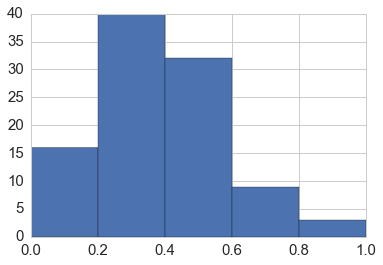

In [85]:
bins = np.arange(0, 1.05, 0.2)
plt.hist(true_q, bins=bins)

### Make a class that will fit this to a smooth distribution (no censoring yet)

In [86]:
#bins = np.arange(0, 1.05, 0.1)
hf = MassRatioDistribution.HistFitter(q, bin_edges=bins)

In [87]:
theta, _ = np.histogram(true_q, bins=bins, normed=True)
hf.lnlike(theta)

389.25841202061883

In [88]:
fit_pars = hf.guess_fit()

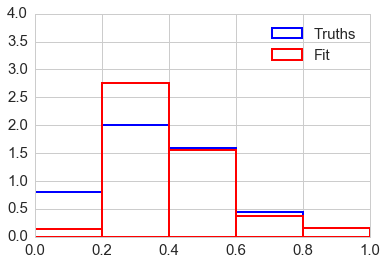

In [89]:
# Plot
plt.bar(left=bins[:-1], width=hf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=hf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

## That seems to work pretty well! Lets add some complexity by adding a censoring function

(-0.05, 1.05)

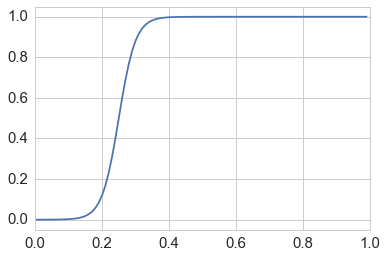

In [90]:
# I will make the censoring function be a sigmoid, but will only use the callable 
def sigmoid(q, alpha, beta):
    return 1.0 / (1.0 + np.exp(-alpha * (q - beta)))

alpha, beta = (40, 0.25)
x = np.arange(0, 1, 0.01)
Q = sigmoid(x, alpha, beta)
plt.plot(x, Q)
plt.ylim((-0.05, 1.05))

In [91]:
# Censor out some of the q, replacing all with nans
R = np.random.uniform(size=true_q.size)
undetected = R > sigmoid(true_q, alpha, beta)
censored_q = q.copy()
censored_q[undetected, :] = np.nan

(array([  1.,  33.,  32.,   9.,   3.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

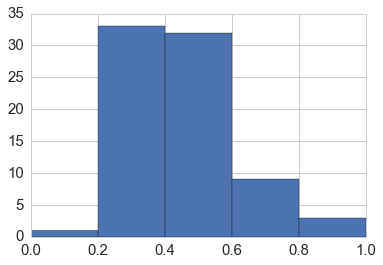

In [92]:
plt.hist(true_q[~undetected], bins=bins)

In [93]:
chf = MassRatioDistribution.CensoredHistFitter(censored_q, bins)
fit_pars = chf.guess_fit()

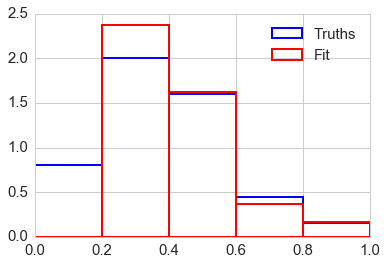

In [94]:
# Plot
plt.bar(left=bins[:-1], width=chf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=chf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
#plt.ylim((0, 6.0))
plt.legend(loc='best', fancybox=True)

### Cool! That mostly gives a reasonable answer too.

Now, I need to add a prior in the form of a gaussian process that forces the histogram to be 'smooth'

In [95]:
shf = MassRatioDistribution.SmoothHistFitter(censored_q, bins)
#shf.lnprob(fit_pars)

In [96]:
fit_pars = shf.guess_fit()

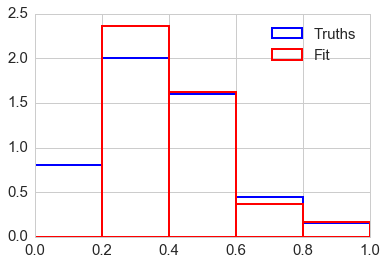

In [97]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=fit_pars[:-4], label='Fit', fill=False, lw=2, edgecolor='red')
#plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

In [107]:
#shf.n_params = shf.Nbins + 4
#shf.param_names = [r'$\theta_{}$'.format(i) for i in range(shf.Nbins)]
#shf.param_names.extend(('lna', 'lntau', 'lnerr', 'mean'))
shf.fit_multinest(basename='HistFitterTest/simulation{}'.format(NP_SEED), overwrite=False)

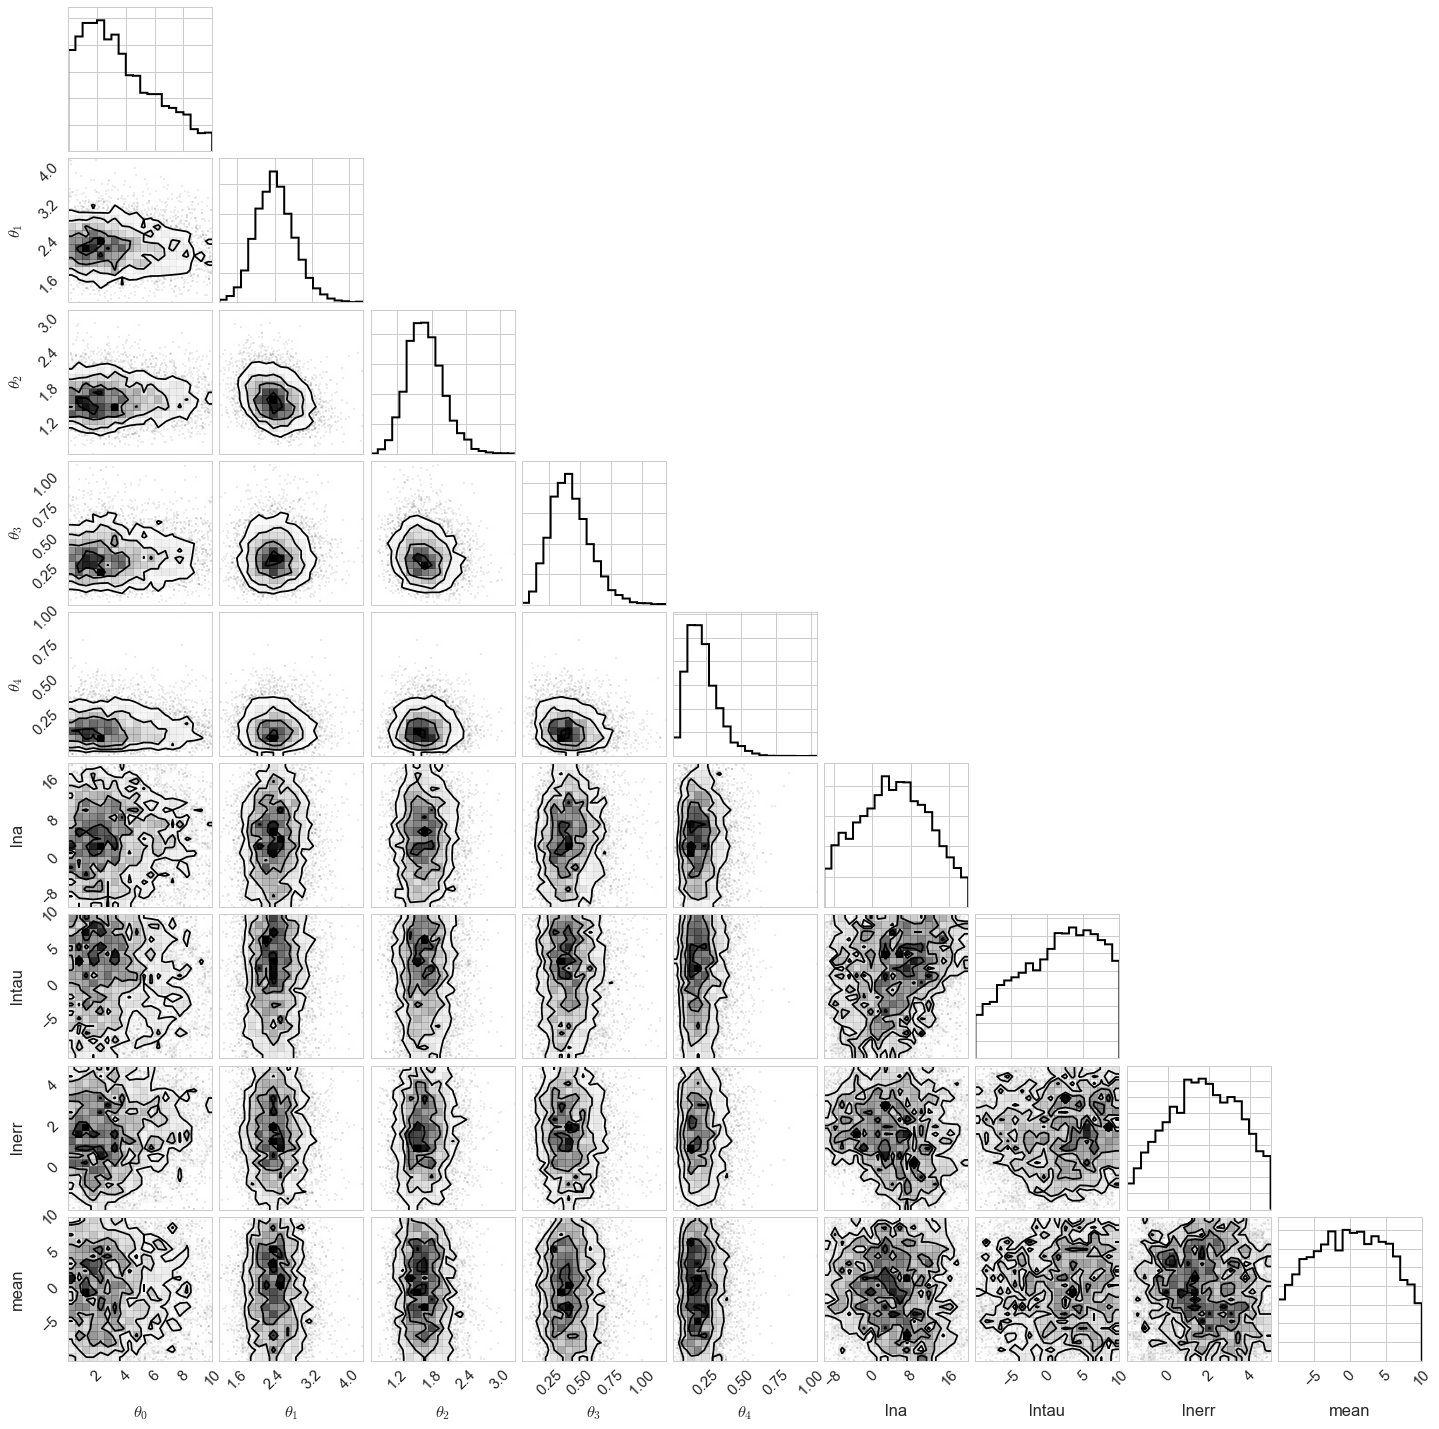

In [108]:
shf.triangle(hist_kwargs=dict(lw=2))

In [109]:
shf.samples.describe()

,$\theta_0$,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,lna,lnerr,lnprob,lntau,mean
count,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000
mean,3.572151,2.419876,1.691272,0.425546,0.222386,4.520408,1.703536,295.726024,1.341802,0.038113
std,2.450883,0.418940,0.315946,0.164040,0.109093,7.187025,1.698353,1.516229,5.283816,5.200489
min,0.000236,1.219789,0.738519,0.025395,0.014550,-9.995955,-1.993506,285.166961,-9.959268,-9.986575
25%,1.593700,2.132940,1.473318,0.309703,0.143021,-0.959485,0.409822,294.939474,-2.824776,-4.172644
50%,3.096140,2.397478,1.667208,0.407081,0.205006,4.513385,1.726593,295.998169,1.871459,0.127361
75%,5.213959,2.675981,1.886501,0.522511,0.280891,9.965005,3.073829,296.829816,5.774066,4.283209
max,9.994487,4.300503,3.248531,1.197486,1.043280,19.981100,4.998860,298.436910,9.997553,9.997986


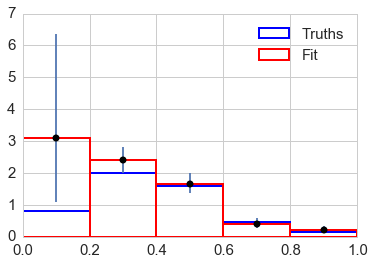

In [110]:
height_mean = np.array([shf.samples[col].mean() for col in shf.param_names[:shf.Nbins]])
height_std = np.array([shf.samples[col].std() for col in shf.param_names[:shf.Nbins]])
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='Fit', fill=False, lw=2, edgecolor='red')
plt.plot(shf.bin_centers, m, 'ko')
#plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

# This works quite nicely!
The uncertainties tend to be very large, especially on the lowest q bin where completeness is very low, but that is fine. I have tried it on several different random seeds, and it always gives a reasonable answer.

# Malmquist bias

The last thing to test out is the malmquist bias correction. My approach is adjust the fitted bins; perhaps a forward modeling approach would be better but meh!

In [111]:
# Set the malmquist bias parameters. This comes from a simulation in Malmquist_Bias.ipynb
malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])

In [112]:
def _integrate_malmquist(malm_pars, q0, q1):
        """ Integrate the malmquist-correction factor from q0 --> q1
        """
        return np.sum([p/(i+1.0)*(q1**(i+1.0) - q0**(i+1.0)) for i, p in enumerate(malm_pars)])
    
def _fit_thetas(raw_thetas, malm_integrals):
        thetas = np.array(raw_thetas)
        thetas[:-1] = np.array([malm_integrals[-1]/Mi * p for Mi, p in zip(malm_integrals[:-1], raw_thetas[:-1])])
        return thetas

def correct_malmquist(bin_edges, bin_heights, malm_pars):
    """ Apply a correction to the fitted bin heights to account for malmquist bias
    """
    # First, calculate the malmquist integrals for every bin
    malm_integrals = np.array([_integrate_malmquist(malm_pars, q0, q1) for q0, q1 
                                in zip(bin_edges[:-1], bin_edges[1:])])
    
    # Calculate new un-normalized bin heights
    malm_vals = _fit_thetas(bin_heights, malm_integrals)
    
    # Normalize such that the sum is the same as the original
    bin_widths = np.diff(bin_edges)
    norm = np.sum(malm_vals * bin_widths) / np.sum(bin_heights * bin_widths)
    malm_vals /= norm
    return malm_vals
    
    

In [113]:
# Test out on the median bin heights from the previous fit
new_theta = correct_malmquist(bin_edges=bins, bin_heights=m, malm_pars=malm_pars[::-1])
print(m)
print(new_theta)

[ 3.09613997  2.39747811  1.66720844  0.40708052  0.20500635]
[ 3.41715578  2.47418379  1.48247405  0.2874769   0.11162288]


In [114]:
# Apply to all of the MCMC samples
current_heights = shf.samples[shf.param_names[:shf.Nbins]].as_matrix()
new_heights = np.vstack([correct_malmquist(bins, height, malm_pars[::-1]) for height in current_heights])

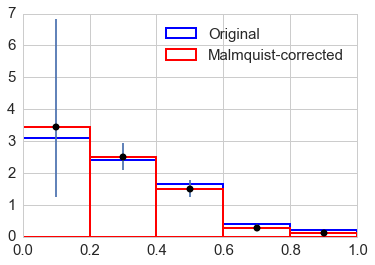

In [115]:
# Plot the malmquist-corrected heights, with errors
l2, m2, h2 = np.percentile(new_heights, [16, 50, 84], axis=0)
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, label='Original', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m2, yerr=(m2-l2, h2-m2), label='Malmquist-corrected', fill=False, lw=2, edgecolor='red')
plt.plot(shf.bin_centers, m2, 'ko')
plt.legend(loc='best', fancybox=True)

There really isn't much change between the before- and after-histograms. However, it does go in the expected direction: low mass-ratios go up and high mass-ratios go down.